In [4]:
import warnings

warnings.filterwarnings("ignore")

import pyspark.sql
from pyspark.sql.functions import *

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from wrangle import wrangle_311

spark = pyspark.sql.SparkSession.builder.getOrCreate()

In [23]:
case = spark.read.csv('case.csv', header = True)
dept = spark.read.csv('dept.csv', header = True)
source = spark.read.csv('source.csv', header = True)

case = (case.withColumn('case_late', case.case_late.cast('boolean'))
            .withColumn('case_status', case.case_status.cast('boolean'))
            .withColumn('num_days_late', case.num_days_late.cast('float'))
            .withColumn('SLA_days', case.SLA_days.cast('float'))
            .withColumn('case_opened_date', to_timestamp(case.case_opened_date, 'M/d/yy H:mm'))
            .withColumn('case_closed_date', to_timestamp(case.case_closed_date, 'M/d/yy H:mm'))
            .withColumn('SLA_due_date', to_timestamp(case.SLA_due_date, 'M/mm/yy H:mm'))
       )
dept = dept.withColumn('dept_subject_to_SLA', dept.dept_subject_to_SLA.cast('boolean'))

df = case.join(source, on = 'source_id', how = 'inner').join(dept, on = 'dept_division')

In [24]:
print("\ndf shape: (%d, %d)\n" % (df.count(), len(df.columns)))
df.show(1, vertical=True)


df shape: (855269, 18)

-RECORD 0--------------------------------------
 dept_division          | Field Operations     
 source_id              | svcCRMLS             
 case_id                | 1014127332           
 case_opened_date       | 2018-01-01 00:42:00  
 case_closed_date       | 2018-01-01 12:29:00  
 SLA_due_date           | 2020-09-01 00:42:00  
 case_late              | false                
 num_days_late          | -998.5088            
 case_closed            | YES                  
 service_request_type   | Stray Animal         
 SLA_days               | 999.0                
 case_status            | null                 
 request_address        | 2315  EL PASO ST,... 
 council_district       | 5                    
 source_username        | svcCRMLS             
 dept_name              | Animal Care Services 
 standardized_dept_name | Animal Care Services 
 dept_subject_to_SLA    | true                 
only showing top 1 row



In [25]:
df.printSchema()

root
 |-- dept_division: string (nullable = true)
 |-- source_id: string (nullable = true)
 |-- case_id: string (nullable = true)
 |-- case_opened_date: timestamp (nullable = true)
 |-- case_closed_date: timestamp (nullable = true)
 |-- SLA_due_date: timestamp (nullable = true)
 |-- case_late: boolean (nullable = true)
 |-- num_days_late: float (nullable = true)
 |-- case_closed: string (nullable = true)
 |-- service_request_type: string (nullable = true)
 |-- SLA_days: float (nullable = true)
 |-- case_status: boolean (nullable = true)
 |-- request_address: string (nullable = true)
 |-- council_district: string (nullable = true)
 |-- source_username: string (nullable = true)
 |-- dept_name: string (nullable = true)
 |-- standardized_dept_name: string (nullable = true)
 |-- dept_subject_to_SLA: boolean (nullable = true)



### 1) How many different cases are there, by department?

In [41]:
df.groupBy('dept_division').count().show()

+--------------------+------+
|       dept_division| count|
+--------------------+------+
|       Miscellaneous| 46165|
|         Solid Waste|   816|
|    Field Operations|119362|
|             Streets| 39193|
|    Waste Collection|220696|
|          District 7|     2|
|Code Enforcement ...|  2189|
|         District 10|     2|
|              Vector|   546|
|        Reservations|     2|
|   Dangerous Premise| 15648|
|     311 Call Center|  2889|
|               Brush| 18610|
|Dangerous Premise...|    36|
|Traffic Engineeri...|  4398|
|Code Enforcement ...|   198|
|          District 2|     3|
|             Signals| 21095|
|Engineering Division|  1397|
|Director's Office...|   521|
+--------------------+------+
only showing top 20 rows



In [35]:
count_by_div = df.groupBy('dept_division').count().toPandas()

In [36]:
count_by_div

,dept_division,count
0,Miscellaneous,46165
1,Solid Waste,816
2,Field Operations,119362
3,Streets,39193
4,Waste Collection,220696
5,District 7,2
6,Code Enforcement (IntExp),2189
7,District 10,2
8,Vector,546
9,Reservations,2


In [43]:
count_by_div.set_index('dept_division',inplace=True)

<Figure size 1152x648 with 0 Axes>

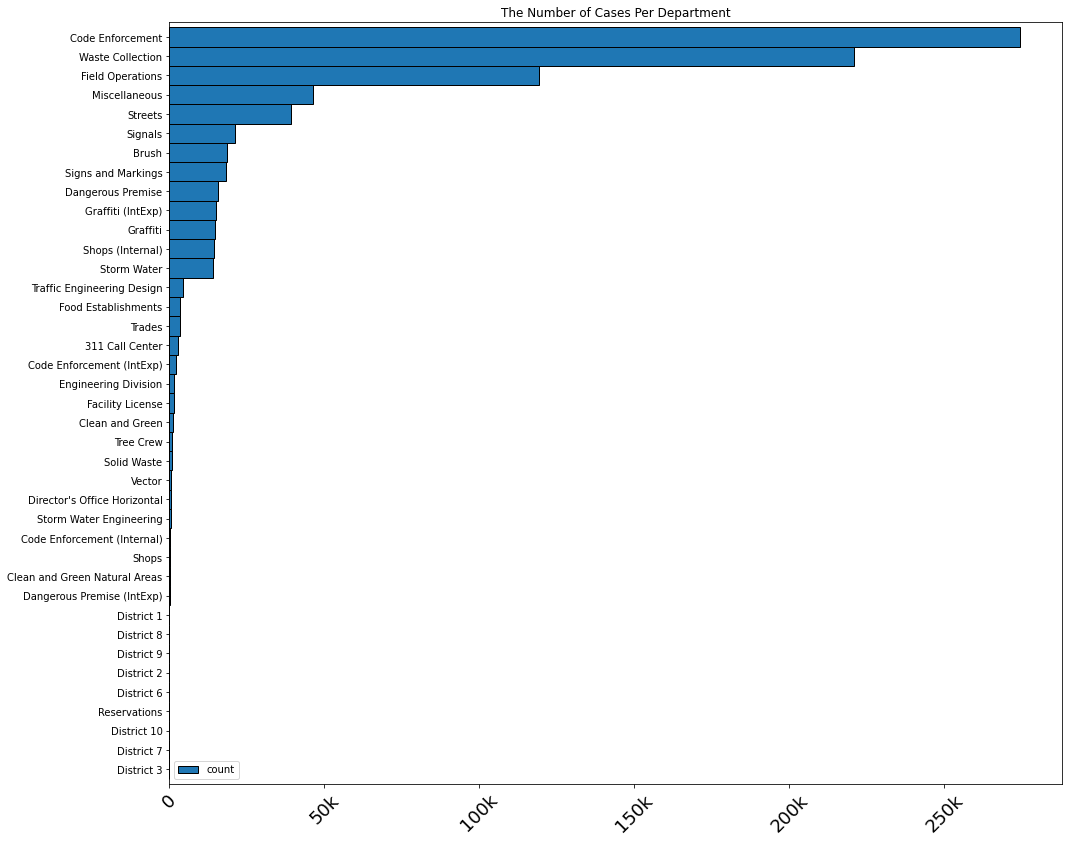

In [123]:
plt.figure(figsize=(16, 9))

count_by_div.sort_values('count', ascending=True).plot.barh(width=1, edgecolor="black", figsize=(16, 14))
plt.xticks([0.0, 50000, 100000, 150000, 200000, 250000], ['0', '50k', '100k', '150k', '200k', '250k'])
plt.xticks(rotation=45, fontsize=18)
plt.title('The Number of Cases Per Department', fontsize)
plt.ylabel('')
plt.show()

### 2) Does the percentage of cases that are late vary by department?

In [57]:
late_dept = df.groupBy('dept_division').pivot('case_late').count().toPandas()

In [95]:
late_dept

,dept_division,false,true,pct_late
0,Miscellaneous,46098.0,67.0,0.001451
1,Solid Waste,479.0,337.0,0.412990
2,Field Operations,95611.0,23751.0,0.198983
3,Waste Collection,189512.0,31184.0,0.141298
4,Streets,35854.0,3339.0,0.085194
6,Code Enforcement (IntExp),1984.0,205.0,0.093650
8,Vector,336.0,210.0,0.384615
10,Dangerous Premise,14641.0,1007.0,0.064353
11,311 Call Center,854.0,2035.0,0.704396
12,Dangerous Premise (IntExp),33.0,3.0,0.083333


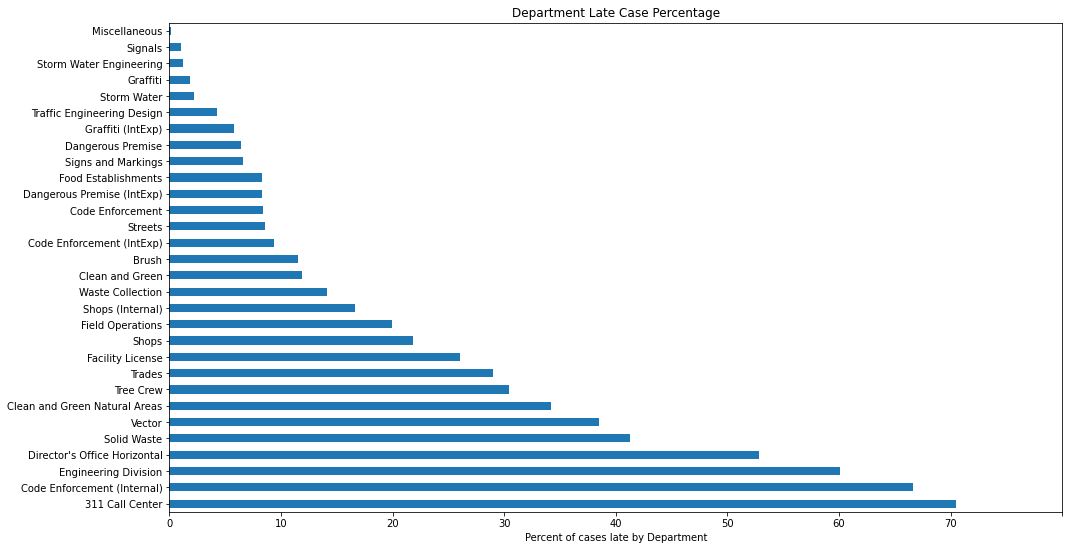

In [116]:
# drop the nulls in the data
late_dept.dropna(inplace = True)

# create a percent col
late_dept['pct_late'] = late_dept.true / (late_dept.false + late_dept.true)

# make the viz
plt.figure(figsize=(16, 9))

late_dept.set_index('dept_division').sort_values(by = 'pct_late',ascending = False).pct_late.plot.barh()

plt.xticks([0.0, .10, .20, .30, .40, .50, .60, .70, .80], ['0', '10', '20', '30', '40', '50', '60', '70'])
plt.xlabel('Percent of cases late by Department')
plt.title("Department Late Case Percentage")
plt.ylabel('')

plt.show()

### 3) On average, how late are the late cases by department?

In [96]:
late_days_by_dept = df.where(df.case_late).groupBy("dept_division").agg(mean("num_days_late")).sort(
    desc("avg(num_days_late)")
).toPandas()

In [97]:
late_days_by_dept

,dept_division,avg(num_days_late)
0,Code Enforcement (Internal),210.892021
1,311 Call Center,88.182482
2,Director's Office Horizontal,77.461619
3,Shops,76.606037
4,Code Enforcement (IntExp),76.413620
5,Engineering Division,67.222485
6,Reservations,66.031162
7,Dangerous Premise,55.880327
8,Code Enforcement,48.817808
9,Tree Crew,33.753187


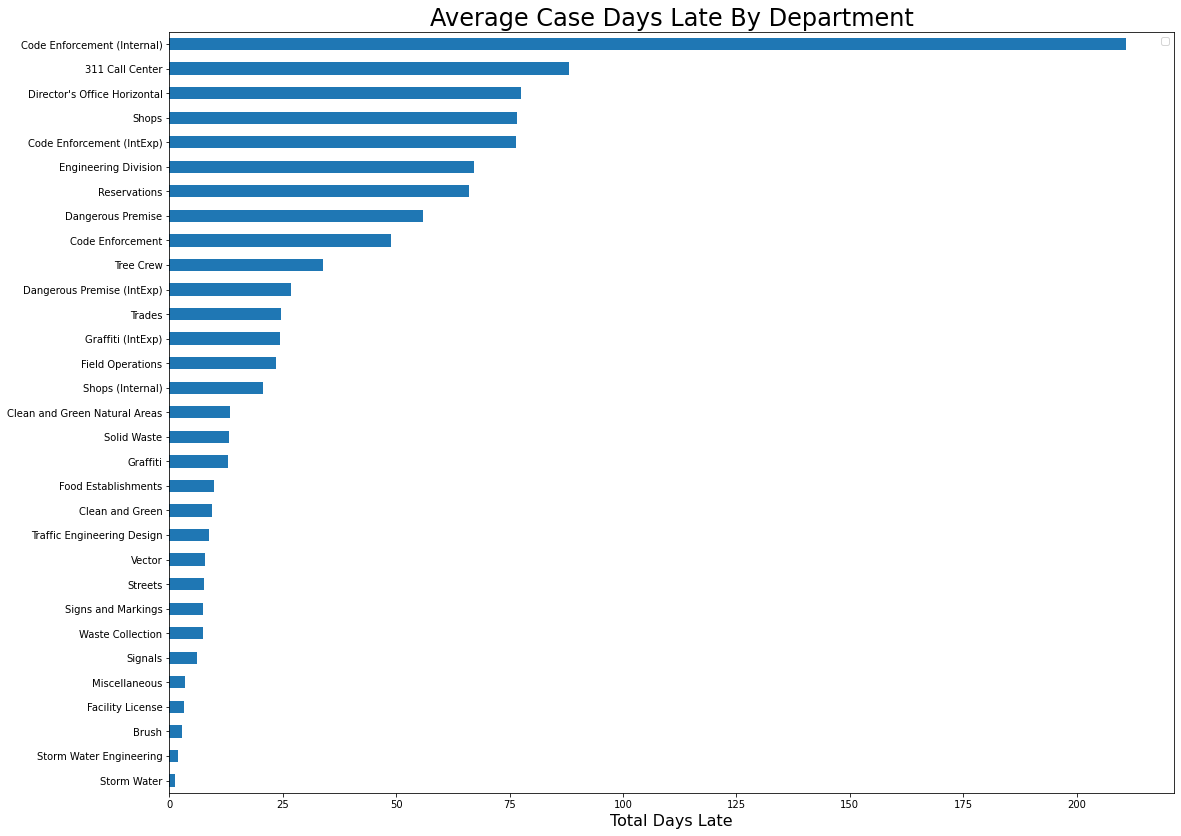

In [107]:
late_days_by_dept.set_index('dept_division').sort_values(by = 'avg(num_days_late)',ascending = True).plot.barh()

plt.gcf().set_size_inches(18, 14)

plt.xlabel('Total Days Late', fontsize=16)
plt.title("Average Case Days Late By Department", fontsize=24)
plt.ylabel('')
plt.legend('')

plt.show()

### 4) What is the service type that is the most late? Just for Parks & Rec?

In [109]:
late_type = df.groupBy('service_request_type').pivot('case_late').count().toPandas()

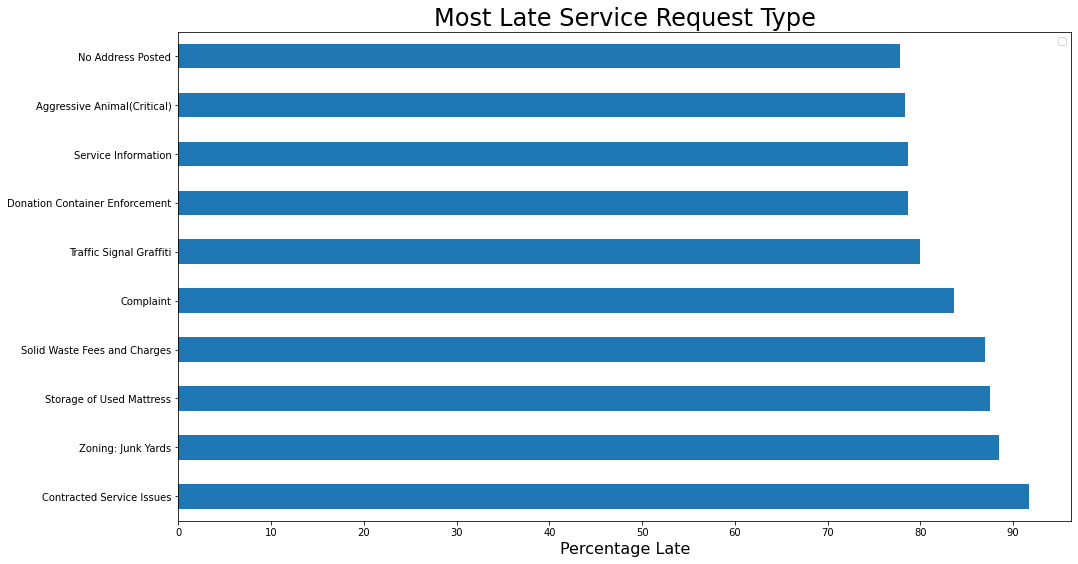

In [120]:
#late_type.set_index('service_request_type', inplace=True)
late_type['late_pct'] = late_type.true / (late_type.false +late_type.true)
late_type.sort_values('late_pct', ascending=False).head(10).late_pct.plot.barh()

plt.gcf().set_size_inches(16, 9)
plt.xticks([0.0, .10, .20, .30, .40, .50, .60, .70, .80, .90], ['0', '10', '20', '30', '40', '50', '60', '70', '80', '90'])
plt.xlabel('Percentage Late', fontsize=16)
plt.title("Most Late Service Request Type", fontsize=24)
plt.ylabel('')
plt.legend('')

plt.show()